In [2]:
import numpy as np
import xarray as xr
import scipy.stats as stats

from dataclasses import dataclass
from typing import Tuple, List, Literal
from enum import Enum

In [5]:

class LongitudeSystem(Enum):
    """Enum for longitude coordinate systems."""
    EAST_WEST = "east_west"      # -180° to 180°
    CONTINUOUS = "continuous"    # 0° to 360°


class LatitudeSystem(Enum):
    """Enum for latitude coordinate systems."""
    NORTH_SOUTH = "north_south"  # 90°N to -90°S
    SOUTH_NORTH = "south_north"  # -90°N to 90°S


@dataclass
class LonLatBox:
    """Dataclass for storing longitude and latitude coordinates with explicit longitude system."""
    lon_min: float
    lon_max: float
    lat_min: float
    lat_max: float
    lon_system: LongitudeSystem = LongitudeSystem.EAST_WEST
    lat_system: LatitudeSystem = LatitudeSystem.NORTH_SOUTH
    
    def __post_init__(self):
        """Basic coordinate validation."""
        # Longitude validation
        if self.lon_system == LongitudeSystem.EAST_WEST:
            if not (-180 <= self.lon_min <= 180 and -180 <= self.lon_max <= 180):
                raise ValueError("Longitudes must be between -180 and 180 for EAST_WEST system")
        else:
            if not (0 <= self.lon_min <= 360 and 0 <= self.lon_max <= 360):
                raise ValueError("Longitudes must be between 0 and 360 for CONTINUOUS system")

        if self.lon_min > self.lon_max:
            raise ValueError("lon_min cannot be greater than lon_max")
        
        # Latitude validation  
        if not (-90 <= self.lat_min <= 90 and -90 <= self.lat_max <= 90):
            raise ValueError("Latitudes must be between -90 and 90")
        
        if self.lat_system == LatitudeSystem.NORTH_SOUTH:
            if self.lat_min < self.lat_max:
                raise ValueError("In NORTH_SOUTH system, lat_min (south) cannot be less than lat_max (north)")
        else:
            if self.lat_min > self.lat_max:
                raise ValueError("In SOUTH_NORTH system, lat_min (north) cannot be greater than lat_max (south)")

    @property
    def lon_min_max(self) -> tuple:
        return self.lon_min, self.lon_max
    
    @property
    def lat_min_max(self) -> tuple:
        return self.lat_min, self.lat_max


@dataclass
class XConfig:
    time_dim: str = "time"
    lon_dim: str = "lon"
    lat_dim: str = "lat"
    

In [14]:
def read_edh(edh_path: str) -> xr.Dataset:
    return xr.open_dataset(
        edh_path,
        storage_options={"client_kwargs":{"trust_env":True}},
        chunks={"time": 1},
        engine="zarr",
    )

In [9]:
def extract_observable(dataset: xr.Dataset, var: str, min_month: int, max_month: int, lon_lat_box: LonLatBox, xconfig: XConfig) -> xr.DataArray: 
    res = dataset[var].resample({xconfig.time_dim: '1D'}).max()
    return res.sel({
        xconfig.time_dim: (res[f"{xconfig.time_dim}.month"]>=min_month) & (res[f"{xconfig.time_dim}.month"]<=max_month),
        xconfig.lat_dim: slice(*lon_lat_box.lat_min_max),
        xconfig.lon_dim: slice(*lon_lat_box.lon_min_max)
    }).mean(dim=[xconfig.lat_dim, xconfig.lon_dim])

In [10]:
paris_box = LonLatBox(1.25, 3.75, 50, 49, LongitudeSystem.CONTINUOUS, LatitudeSystem.NORTH_SOUTH)
xconfig = XConfig("valid_time", "longitude", "latitude")

In [11]:
var = "t2m"
min_month = 5
max_month = 9
lon_lat_box = paris_box

In [15]:
singles_path = "https://data.earthdatahub.destine.eu/era5/reanalysis-era5-single-levels-v0.zarr"
era5_ds = read_edh(singles_path)

In [16]:
era5_ds = era5_ds.sel(valid_time=slice("1940-01-01", "1950-01-01"))

In [17]:
res = era5_ds["t2m"].resample({"valid_time": '1D'}).max()

In [22]:
res = res.rename({"valid_time": "time", "latitude": "lat", "longitude": "lon"})

In [32]:
res_ds = res.to_dataset(name='t2m')

In [34]:
res

<xarray.DataArray 't2m' (time: 3654, lat: 721, lon: 1440)> Size: 15GB
dask.array<stack, shape=(3654, 721, 1440), dtype=float32, chunksize=(1, 64, 64), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 29kB 1940-01-01 1940-01-02 ... 1950-01-01
  * lat      (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
    number   int64 8B ...
    surface  float64 8B ...
Attributes: (12/31)
    GRIB_NV:                                  0
    GRIB_Nx:                                  1440
    GRIB_Ny:                                  721
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           t2m
    GRIB_dataType:                            an
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               K
    GRIB_uvRelativeToGrid:                    0
    long_name:                                2 metre temperature
    standard_name:                            unknown
    units:                                    K

In [ ]:
rolling_periods_tab = np.array([1,3,5,11,15,31])
level_tab = np.array([0.5,0.75,0.95,0.99,0.999,0.9999])

# Load dates closest neighbors 
closest_neighbors_list = []
for idr,r in enumerate(rolling_periods_tab):
    temp = []
    for l in level_tab:
        temp.append(xr.load_dataarray("./outputs/paris/"+"data_closest/closest_neighbors_obs_r"+str(r)+"_q"+str(l)+".nc", use_cftime=True))
    closest_neighbors_list.append(temp)

In [12]:
closest_neighbors_list[0][5].time.sortby('time', ascending=False).values

array([cftime.DatetimeProlepticGregorian(3936, 6, 22, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(3903, 8, 12, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(3884, 6, 5, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(3808, 7, 4, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(3762, 6, 18, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(3722, 6, 19, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(3716, 8, 13, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(3652, 6, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(3614, 6, 28, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(3596, 7, 5, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(3566, 7, 26, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(3551,

In [14]:
obs = extract_observable(era5_ds, var, min_month, max_month, lon_lat_box, xconfig).compute()

In [48]:
params = stats.genextreme.fit(obs.values)

n_years = 2000
days_per_season = 153  # May 1 - Sept 30
n_samples = n_years * days_per_season

synthetic_data = stats.genextreme.rvs(*params, size=n_samples)

dates = np.array([], dtype='datetime64[D]')
for year in range(1940, 1940 + n_years):
    year_dates = np.arange(np.datetime64(f'{year}-05-01'), np.datetime64(f'{year}-10-01'), dtype='datetime64[D]')
    dates = np.append(dates, year_dates)

In [51]:
synthetic_da = xr.DataArray(
    synthetic_data,
    dims=['time'],
    coords={'time': dates},
    name='synthetic_daily_max'
)
synthetic_ds = xr.Dataset({
    't2m': synthetic_da
})

In [2]:
ds = xr.load_dataset("./synthetic_data.nc")

/tmp/ipykernel_37946/2672125805.py:1: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xr.load_dataset("./synthetic_data.nc")
/tmp/ipykernel_37946/2672125805.py:1: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xr.load_dataset("./synthetic_data.nc")


In [3]:
ds

<xarray.Dataset> Size: 5MB
Dimensions:  (time: 306000)
Coordinates:
  * time     (time) object 2MB 1940-05-01 00:00:00 ... 3939-09-30 00:00:00
Data variables:
    t2m      (time) float64 2MB 289.3 295.0 288.9 290.9 ... 297.7 292.5 294.9

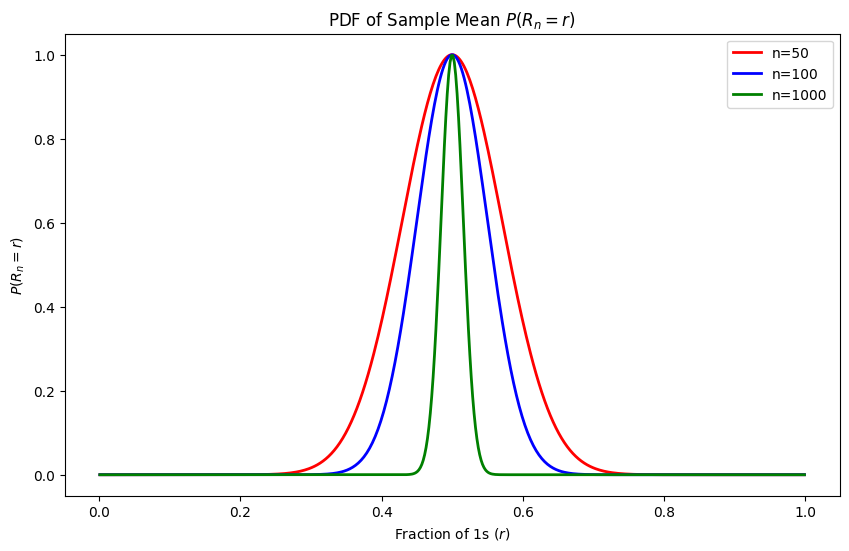

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb

def rate_function_I(r):
    """
    The rate function I(r) from Equation (3).
    I(r) = ln(2) + r*ln(r) + (1-r)*ln(1-r)
    """
    # Use a small epsilon to handle r=0 and r=1 safely, as x*ln(x) approaches 0.
    epsilon = 1e-15
    r = np.clip(r, epsilon, 1 - epsilon)
    
    # Calculate the function
    I_r = np.log(2) + r * np.log(r) + (1 - r) * np.log(1 - r)
    return I_r

def probability_approx(r, n):
    """
    The Large Deviation Approximation: P(R_n = r) ≈ exp(-n * I(r))
    """
    I_r = rate_function_I(r)
    return np.exp(-n * I_r)

def probability_exact(k, n):
    """
    The Exact Binomial Probability: P(k successes) = (1/2^n) * nCk
    R_n = r = k/n
    """
    # Ensure k is within bounds [0, n]
    k = np.clip(k, 0, n)
    return (1 / 2**n) * comb(n, k)

n_s = [50, 100, 1000]  

colours = ["r", "b", "g"]

r_approx = np.linspace(0.001, 0.999, 500)


fig, ax = plt.subplots(figsize=(10, 6))

for i, n in enumerate(n_s):
    P_approx = probability_approx(r_approx, n)

    k_vals = np.arange(0, n + 1)
    r_exact = k_vals / n
    P_exact = probability_exact(k_vals, n)

    # Plot the smooth approximation curve (Eq 3)
    ax.plot(r_approx, P_approx, f'{colours[i]}-', linewidth=2, 
            label=f'n={n}')

# # Plot the exact discrete points
# ax.plot(r_exact, P_exact, 'bo', markersize=4, 
#         label='Exact Binomial Probability')

ax.set_title(f"PDF of Sample Mean $P(R_n = r)$")
ax.set_xlabel("Fraction of 1s ($r$)")
ax.set_ylabel("$P(R_n = r)$")
ax.legend()
# ax.grid(True, alpha=0.5)

# # Highlight the central region where I(r) is near zero
# ax.axvline(x=0.5, color='k', linestyle='--', alpha=0.5)
# ax.text(0.5, 0.001, "$r = 1/2$", ha='left')


## Examples

In [1]:
import joblib

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb

def theoretical_rate_function(r):
    epsilon = 1e-15
    r = np.clip(r, epsilon, 1 - epsilon)
    
    return np.log(2) + r * np.log(r) + (1 - r) * np.log(1 - r)

def run_simulation(n_bits, n_trials):
    sums_final = np.zeros((trials,))

    r = n_bits // 100
    for _ in range(r):
        bits = np.random.randint(0, 2, size=(trials, 100))
        sums_final += np.sum(bits, axis=1)

    fractions = sums_final / n_bits
    
    unique_fractions, counts = np.unique(fractions, return_counts=True)
    empirical_probs = counts / n_trials
    
    return unique_fractions, empirical_probs

n = 100
trials = 1000000

r_emp, p_emp = run_simulation(n, trials)

empirical_rate = - (1/n) * np.log(p_emp)

r_theory = np.linspace(0, 1, 500)
I_theory = theoretical_rate_function(r_theory)

# Calculate Exact Analytical Probability for finite n (Eq 2)
# P(Rn=r) = (1/2^n) * nCk
k_vals = np.arange(0, n + 1)
r_exact = k_vals / n
p_exact = (1 / 2**n) * comb(n, k_vals)
rate_exact = - (1/n) * np.log(p_exact)

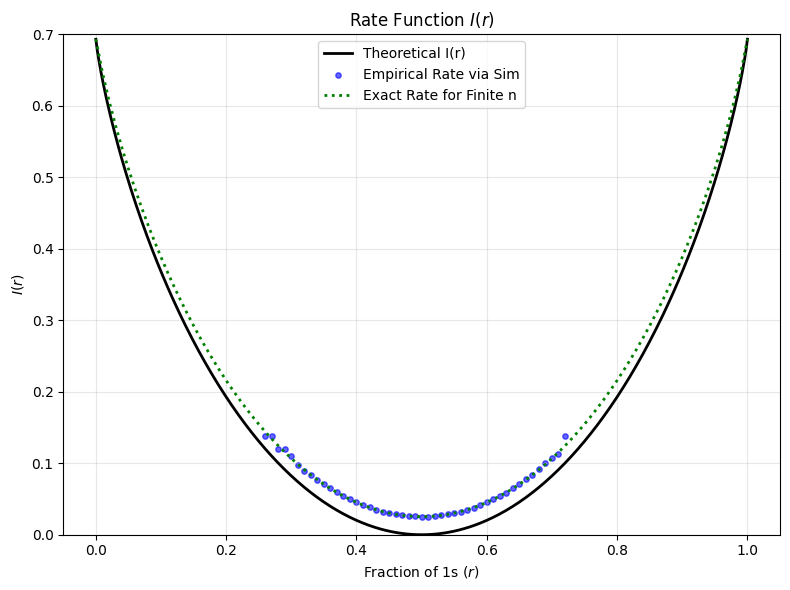

In [11]:
# --- Plotting ---
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# # Plot 1: Standard Probability Scale
# ax[0].plot(r_theory, np.exp(-n * I_theory), 'r--', label='Large Deviation Approx', linewidth=2)
# ax[0].scatter(r_emp, p_emp, alpha=0.6, s=10, color='blue', label='Simulated Data')
# ax[0].set_title(f"Probability Distribution $P(R_n = r)$ (n={n})")
# ax[0].set_xlabel("Fraction of 1s ($r$)")
# ax[0].set_ylabel("Probability")
# ax[0].legend()
# ax[0].grid(True, alpha=0.3)

# Plot 2: Rate Function Scale (The "Log" view)
# This allows us to see the parabolic shape described in the text
ax.plot(r_theory, I_theory, 'k-', linewidth=2, label='Theoretical I(r)')
ax.scatter(r_emp, empirical_rate, color='blue', s=15, alpha=0.6, label='Empirical Rate via Sim')
ax.plot(r_exact, rate_exact, 'g:', linewidth=2, label='Exact Rate for Finite n')

ax.set_title("Rate Function $I(r)$")
ax.set_xlabel("Fraction of 1s ($r$)")
ax.set_ylabel("$I(r)$")
ax.set_ylim(0, 0.7) # Focus on the bottom curve
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<>:67: SyntaxWarning: invalid escape sequence '\m'
<>:67: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_11381/2565358.py:67: SyntaxWarning: invalid escape sequence '\m'
  ax[1].annotate('Minimum at $\mu$', xy=(mu, 0), xytext=(mu, 0.1),


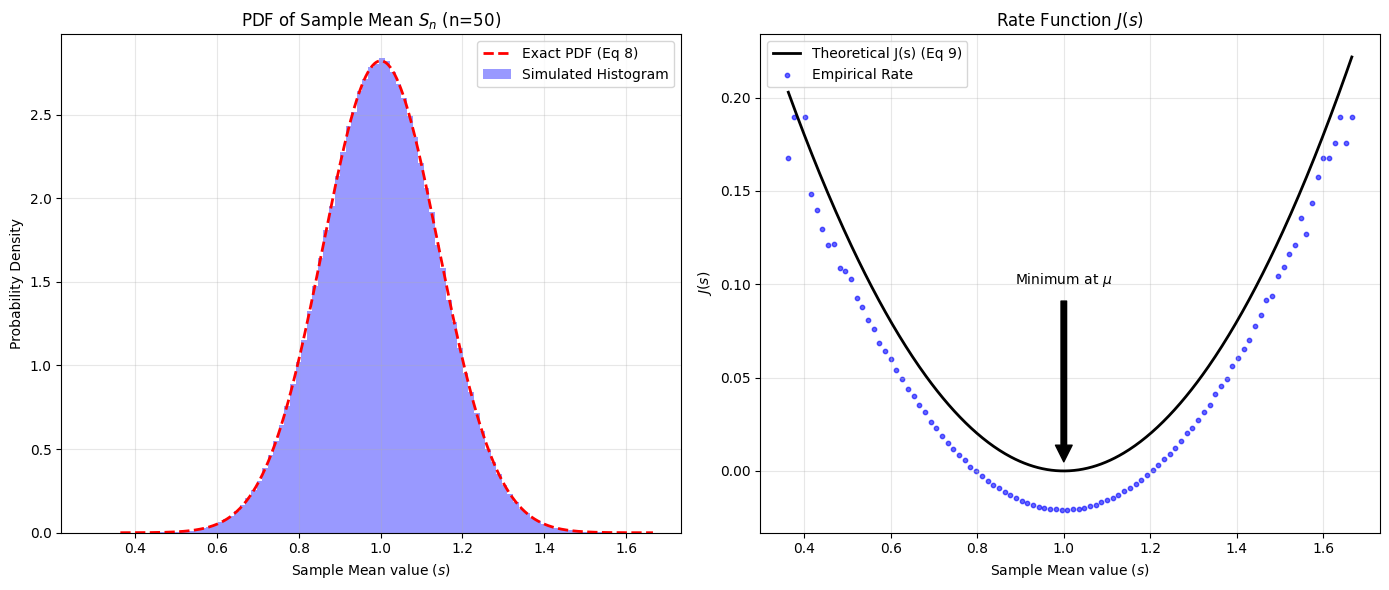

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def theoretical_rate_function(s, mu, sigma):
    return (s - mu)**2 / (2 * sigma**2)

def exact_pdf(s, n, mu, sigma):
    prefactor = np.sqrt(n / (2 * np.pi * sigma**2))
    exponent = -n * (s - mu)**2 / (2 * sigma**2)
    return prefactor * np.exp(exponent)

def run_gaussian_simulation(n, trials, mu, sigma, bins = 100):
    X = np.random.normal(loc=mu, scale=sigma, size=(trials, n))
    
    S_n = np.mean(X, axis=1)
    
    counts, bin_edges = np.histogram(S_n, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    return bin_centers, counts

n = 50           
trials = 1000000 
mu = 1.0        
sigma = 1.0      

s_vals, pdf_emp = run_gaussian_simulation(n, trials, mu, sigma)

# --- Calculate Empirical Rate Function ---
# From Eq (9): p(Sn=s) ≈ exp(-n * J(s))
# Therefore: J(s) ≈ -1/n * ln(p(Sn=s))
# We filter out zero counts to avoid log(0)
valid_indices = pdf_emp > 0
s_valid = s_vals[valid_indices]
pdf_valid = pdf_emp[valid_indices]
empirical_rate = - (1/n) * np.log(pdf_valid)

# --- Theoretical Curves ---
s_theory = np.linspace(min(s_vals), max(s_vals), 500)
J_theory = theoretical_rate_function(s_theory, mu, sigma)
pdf_theory = exact_pdf(s_theory, n, mu, sigma)



# Plot 2: Rate Function Scale (The Parabola)
# J(s) = (s-mu)^2 / 2sigma^2
ax[1].plot(s_theory, J_theory, 'k-', linewidth=2, label='Theoretical J(s) (Eq 9)')
ax[1].scatter(s_valid, empirical_rate, color='blue', s=10, alpha=0.6, label='Empirical Rate')

ax[1].set_title("Rate Function $J(s)$")
ax[1].set_xlabel("Sample Mean value ($s$)")
ax[1].set_ylabel("$J(s)$")
ax[1].legend()
ax[1].grid(True, alpha=0.3)

# Annotate the minimum
ax[1].annotate('Minimum at $\mu$', xy=(mu, 0), xytext=(mu, 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05),
             ha='center')

plt.tight_layout()
plt.show()

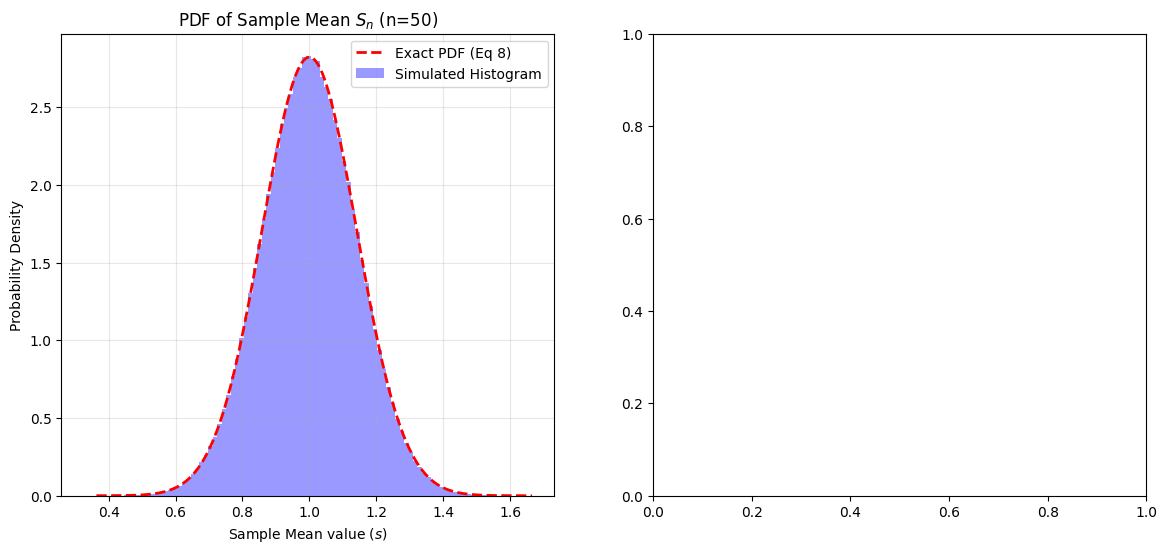

In [11]:
# --- Plotting ---
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: PDF Scale (The Bell Curve)
ax[0].plot(s_theory, pdf_theory, 'r--', linewidth=2, label='Exact PDF (Eq 8)')
ax[0].hist(np.random.normal(mu, sigma/np.sqrt(n), trials), bins=100, density=True, 
           alpha=0.4, color='blue', label='Simulated Histogram')
ax[0].set_title(f"PDF of Sample Mean $S_n$ (n={n})")
ax[0].set_xlabel("Sample Mean value ($s$)")
ax[0].set_ylabel("Probability Density")
ax[0].legend()
ax[0].grid(True, alpha=0.3)